In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import janitor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import  mean_absolute_error,accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import xgboost as xgb
import smogn
import optuna
import warnings

warnings.filterwarnings('ignore') #Se cargan todas las librerias necesarias para utilizar (Algunas no estan siendo utilizadas porque se utilizaron anteriormente como medida de prevension)

In [2]:
try:
  filepath = 'C:\\Users\\adria\Documents\\Programacion\\Python 2\\Datos normalizados.xlsx'
  df= pd.read_excel(filepath)
  df= pd.DataFrame(df)
  df_clean= df.clean_names()
  print(f"El archivo se ha cargado y limpieado correctamente")
except FileNotFoundError:
   print(f"El archivo no ha sido encontrado")  #Cargamos el archivo

AttributeError: 'DataFrame' object has no attribute 'clean_names'

In [ ]:
#Informacion general del dataset
print(f'''\nINFORMACIÓN GENERAL DEL DATASET:\n
    - Dimensiones: {df_clean.shape[0]} filas x {df_clean.shape[1]} columnas \n
    - Período de análisis: dataset historico de préstamos bancarios
''')

print(f'''
    \n📊 ESTRUCTURA DEL DATASET: \n{df_clean.info} \n
    \n📈 ESTADÍSTICA DESCRIPTIVA: \n {df_clean.describe()}
    ''')


INFORMACIÓN GENERAL DEL DATASET:

    - Dimensiones: 11929 filas x 35 columnas 

    - Período de análisis: dataset historico de préstamos bancarios


    
📊 ESTRUCTURA DEL DATASET: 
<bound method DataFrame.info of             cuenta  identificacion                           cliente  \
0      10010000504       911782688  RODRIGUEZ ROMERO BOLIVAR ENRIQUE   
1      10010000561       941027443          GILCE RIVAS ALEX ALFREDO   
2      10010000562       941027443          GILCE RIVAS ALEX ALFREDO   
3      10010000621       941235392   CARVAJAL TOMALA DAYANARA NICOLE   
4      10010000622       941235392   CARVAJAL TOMALA DAYANARA NICOLE   
...            ...             ...                               ...   
11924   1001080592      1103845796      BRICENO CAMACHO MIGUEL ANGEL   
11925   1001082011       922071022   ZAMBRANO MANOSALVAS JUAN CARLOS   
11926   1001082011       922071022   ZAMBRANO MANOSALVAS JUAN CARLOS   
11927   1001082012       922071022   ZAMBRANO MANOSALVAS JUAN CA

In [ ]:
#Busco valores faltantes dentro del archivo
print('Valores faltantes:')
missing_values = df_clean.isnull().sum()
missing_percentage = (missing_values / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values, 
    'Porcentaje': missing_percentage
}).sort_values('Porcentaje',ascending=False)
print(missing_df[missing_df['Valores Faltantes'] > 0])

calificacion_distribution = df_clean['calificacion'].value_counts()
calificacion_percentage = calificacion_distribution.value_counts(normalize=True)  * 100
#Reviso los valores unicos y la distribucion de estos, es decir cuantos hay
print(f'''
    \n📊 · Valores únicos en Calificacion: {df_clean['calificacion'].unique()}\n
    \n📈 · Distribución): \n{calificacion_distribution}''')

Valores faltantes:
                         Valores Faltantes  Porcentaje
tipo_canal                           11929  100.000000
porcentaje_discapacidad               3895   32.651522
discapacidad                          3880   32.525778
fecha_ult_movimiento                   288    2.414285

    
📊 · Valores únicos en Calificacion: ['A1' 'B1' 'C1' 'E1' 'A2' 'D1']

    
📈 · Distribución): 
calificacion
A1    11395
A2      337
B1       68
C1       54
E1       53
D1       22
Name: count, dtype: int64


In [ ]:

#Otorgo un significado a las variables de la columna que quiero predecir
df_clean['calificacion_label'] = df_clean['calificacion'].map({''
  'A1':'Aprobado',
  'A2':'Aprobado',
  'B1':'Aprobado',
  'C1':'Aprobado con seguimiento',
  'D1': 'No Aprobado',
  'E1': 'No Aprobado'})
label_distribution = df_clean['calificacion_label'].value_counts()
label_percentage = label_distribution.value_counts(normalize=True) * 100

calificacion_distribution = df_clean['calificacion'].value_counts().sort_index()
calificacion_percentage = df_clean['calificacion'].value_counts(normalize=True).sort_index() * 100

print("\n📈 DISTRIBUCIÓN NUMÉRICA:")
for valor in sorted(calificacion_distribution.index):
    print(f"  {valor}: {calificacion_distribution[valor]:,} casos ({calificacion_percentage[valor]:.1f}%)")


📈 DISTRIBUCIÓN NUMÉRICA:
  A1: 11,395 casos (95.5%)
  A2: 337 casos (2.8%)
  B1: 68 casos (0.6%)
  C1: 54 casos (0.5%)
  D1: 22 casos (0.2%)
  E1: 53 casos (0.4%)


<function matplotlib.pyplot.show(close=None, block=None)>

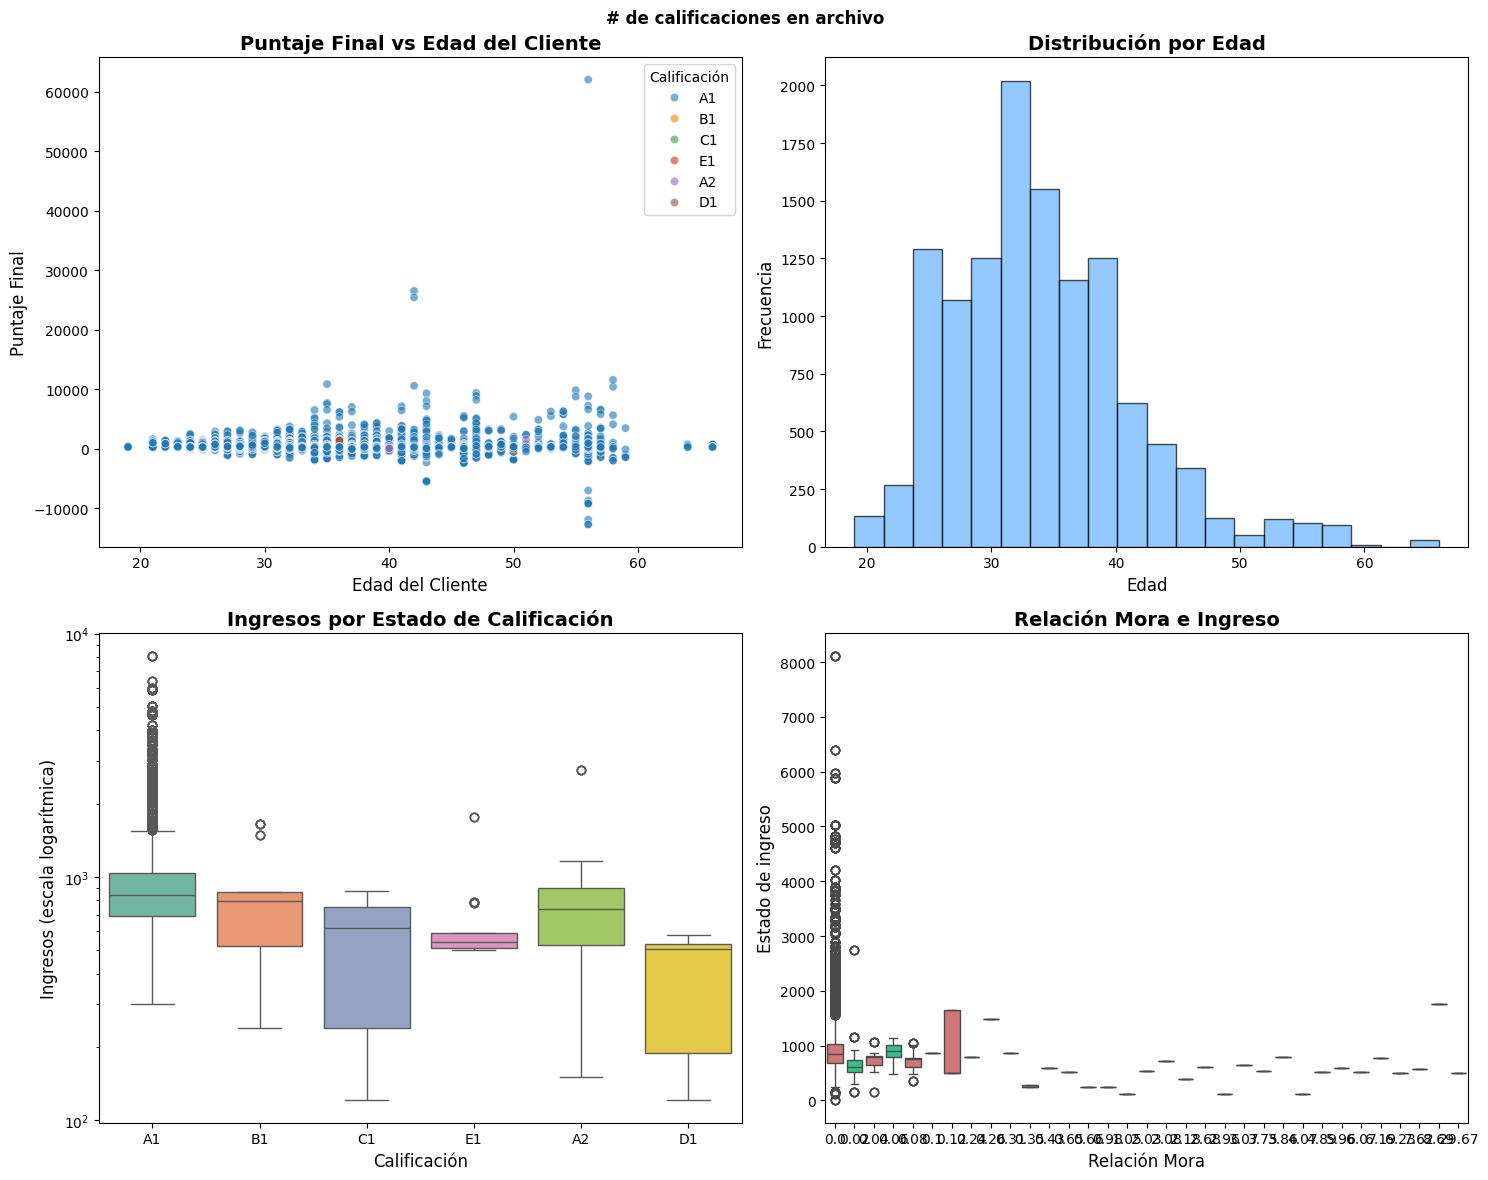

In [ ]:
label_distribution = df_clean['calificacion_label'].value_counts()
fig, ax = plt.subplots(2,2, figsize=(15,12))
fig.suptitle('# de calificaciones en archivo', fontsize=12, fontweight='bold')

# Gráfico 1: Cliente vs puntaje final
sns.scatterplot(data=df_clean, x='edad_cliente', y='puntaje', hue='calificacion', alpha=0.6, ax=ax[0,0])
ax[0,0].set_title('Puntaje Final vs Edad del Cliente', fontsize=14, fontweight='bold')
ax[0,0].set_xlabel('Edad del Cliente', fontsize=12)
ax[0,0].set_ylabel('Puntaje Final', fontsize=12)
ax[0,0].legend(title='Calificación')


# Gráfico 2: Distribución por edad
ax[0,1].hist(df_clean['edad_cliente'], bins=20, alpha=.7, color='#66b3ff', edgecolor='black')
ax[0,1].set_title('Distribución por Edad', fontsize=14, fontweight='bold')
ax[0,1].set_xlabel('Edad', fontsize=12)
ax[0,1].set_ylabel('Frecuencia', fontsize=12)

# Gráfico 3: Ingresos VS Calificacion
sns.boxplot(data=df_clean, x='calificacion', y='ingresos', palette='Set2', ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_title('Ingresos por Estado de Calificación', fontsize=14, fontweight='bold')
ax[1,0].set_xlabel('Calificación', fontsize=12)
ax[1,0].set_ylabel('Ingresos (escala logarítmica)', fontsize=12)


# Gráfico 4: Relación Deuda-Ingreso VS Default
sns.boxplot(x='mora', y='ingresos', data=df_clean, ax=ax[1, 1], palette=["#de6767", "#1bda91"])
ax[1,1].set_title('Relación Mora e Ingreso', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('Relación Mora', fontsize=12)
ax[1,1].set_ylabel('Estado de ingreso', fontsize=12)

plt.tight_layout()
plt.show

In [ ]:
#Comienzo con la separacion de los datos que quiero utilizar (x) para predecir la columna objetivo
y= df_clean['calificacion']
x= df_clean[['saldo','ahorro_general','sexo','saldo_por_vencer','saldo_pendiente','provision','dias_mora','edad_cliente','estado_civil','mora','antiguedad_meses','ingresos','descuentos']]

In [ ]:
Cols_predict = ['saldo','ahorro_general','sexo','saldo_por_vencer','saldo_pendiente','provision','dias_mora','edad_cliente','estado_civil','mora','antiguedad_meses','ingresos','descuentos','puntaje']
df_balanced = smogn.smoter(data=df_clean[Cols_predict], y='puntaje')
x_balanced=df_balanced.drop('puntaje', axis=1)
y_balanced=df_balanced['puntaje']

r_index: 100%|##########| 1481/1481 [00:01<00:00, 792.47it/s]


In [ ]:
x= pd.get_dummies(x, drop_first=True) #Asigna valores binarios para los datos con palabras
x_balanced=pd.get_dummies(x_balanced, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Dividimos los datos 80% entrenamiento 20% prueba
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

In [ ]:
#Genero un pipeline (defino una cadena de eventos para el momento que lo llame) con el que pueda entrenar, modelar, equilibrar, ejecutar y medir su score para saber que tan acertiva es.
def pipeline(trial):
    n_estimators = trial.suggest_int("n_estimators",50,70)
    max_depth= trial.suggest_int("max_depth",25,32)
    min_samples_split= trial.suggest_int("min_samples_split",15,25)
    min_samples_leaf= trial.suggest_int("min_samples_leaf",4,8)
    
    pipeline = imbpipeline([
            ('Sm',SMOTE(random_state=42)),
            ('RFC',RandomForestClassifier( 
                n_estimators= n_estimators,         
                max_depth=max_depth,            
                min_samples_split=min_samples_split,     
                min_samples_leaf=min_samples_leaf,       
                max_features=0.2,      
                random_state=42,
                n_jobs=-1,
                class_weight='balanced'
            ))
        ])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x_train, y_train, cv=skf, scoring='accuracy')
    return scores.mean()

In [ ]:
#def pipeline_lineal(trial):
#    n_estimators = trial.suggest_int("n_estimators",80,160)
#    max_depth= trial.suggest_int("max_depth",60,80)
#    min_samples_split= trial.suggest_int("min_samples_split",25,40)
#    min_samples_leaf= trial.suggest_int("min_samples_leaf",10,20)
#    
#    pipeline2 = imbpipeline([
#                ('RFC',RandomForestRegressor(
#                n_estimators = n_estimators,
#                max_depth=max_depth,            
#                min_samples_split=min_samples_split,     
#                min_samples_leaf=min_samples_leaf,       
#                max_features=0.2,      
#                random_state=42,
#                n_jobs=-1,
#            ))
#        ])
#    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#    scores2 = cross_val_score(pipeline2, x_train2, y_train2, cv=kf, scoring='r2')
#    return scores2.mean()

def objetivo(trial):
   n_estimators= trial.suggest_int('n_estimators',20,80)
   learning_rate= trial.suggest_float('learning_rate',0.01,0.3)
   max_depth=trial.suggest_int('max_depth',15,30)
   subsample= trial.suggest_float('subsample',0.5,1.0)
   colsample_bytree= trial.suggest_float('colsample_bytree',0.5,1.0)
   gamma=trial.suggest_int('gamma',1,5)
   reg_alpha=trial.suggest_int('reg_alpha',1,5)
   reg_lambda= trial.suggest_int('reg_lambda',1,5)
        
   modelo= xgb.XGBRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      learning_rate=learning_rate,
      subsample=subsample,
      colsample_bytree=colsample_bytree,
      gamma=gamma,
      reg_alpha=reg_alpha,
      reg_lambda=reg_lambda,
      random_state=42,
      n_jobs=-1
   )
   kf = KFold(n_splits=5, shuffle=True, random_state=42)
   score = cross_val_score(modelo,x_train2,y_train2, cv=kf, scoring='r2')
   return score.mean()

In [ ]:
#Utilizo optuna para que me ayude a sacar la mejor version posible del pipeline con 150 intentos.
study = optuna.create_study(direction="maximize")
study.optimize(pipeline, n_trials=30)

study2 = optuna.create_study(direction="maximize")
study2.optimize(objetivo, n_trials=250)

[I 2025-09-21 13:27:11,361] A new study created in memory with name: no-name-962773e1-b2aa-43d5-9f53-97072c4d3044
[I 2025-09-21 13:27:13,815] Trial 0 finished with value: 0.9998952331063384 and parameters: {'n_estimators': 63, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9998952331063384.
[I 2025-09-21 13:27:15,724] Trial 1 finished with value: 0.9998952331063384 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9998952331063384.
[I 2025-09-21 13:27:17,897] Trial 2 finished with value: 0.9998952331063384 and parameters: {'n_estimators': 61, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9998952331063384.
[I 2025-09-21 13:27:20,248] Trial 3 finished with value: 0.9998952331063384 and parameters: {'n_estimators': 70, 'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 0 with value

In [ ]:
#Encapsulo los mejores parametros y los utilizo para el modelo de machine learning
best_parameters=study.best_params
best_parameters2=study2.best_params

pipeline = imbpipeline([
    ('Sm',SMOTE(random_state=42)),
    ('RFC',RandomForestClassifier( 
        n_estimators= best_parameters['n_estimators'],         
        max_depth=best_parameters['max_depth'],            
        min_samples_split=best_parameters['min_samples_split'],     
        min_samples_leaf=best_parameters['min_samples_leaf'],       
        max_features=0.2,      
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
      ))
])

modelo = xgb.XGBRegressor( 
        n_estimators= best_parameters2['n_estimators'],         
        max_depth=best_parameters2['max_depth'],     
        learning_rate=best_parameters2['learning_rate'],     
        subsample=best_parameters2['subsample'],
        colsample_bytree=best_parameters2['colsample_bytree'],
        gamma=best_parameters2['gamma'],
        reg_alpha=best_parameters2['reg_alpha'],
        reg_lambda=best_parameters2['reg_lambda'],
        max_features=0.2,      
        random_state=42,
        n_jobs=-1,
      )

In [ ]:
#Lo entreno y comienzo a realizar las pruebas de que tan acertivo es
pipeline.fit(x_train, y_train)
modelo.fit(x_train2, y_train2)

#Predicciones con los modelos
y_predRFC = pipeline.predict(x_test)
y_probaRFC = pipeline.predict_proba(x_test)[:, :]
y_predRFC2 = modelo.predict(x_test2)


Text(0.5, 1.0, 'Matriz de Confusión')

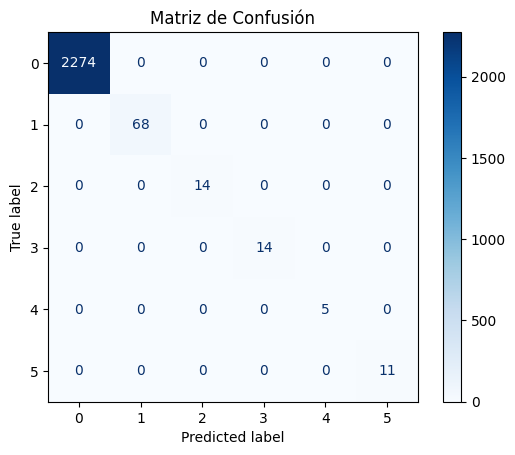

In [ ]:
#vuelvo a medir el modelo con los datos de entrenamiento, pero con el mejor pipeline para saber que tanto puede equivocarse
scores= cross_val_score( pipeline, x_train,y_train, scoring='accuracy')
scores2= cross_val_score( modelo, x_train2,y_train2, scoring='accuracy')
#Matriz de Confusion
#con esto mido que tanto se ha podido equivocar el modelo
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_predRFC))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")


In [ ]:
print("Accuracy (RFC):", accuracy_score(y_test, y_predRFC)) #Compara las precisiones

print("Reporte de clasificación (RFC):\n", classification_report(y_test, y_predRFC)) #Puntuacion de datos por clase 

print("Matriz de confusión (RFC):\n", confusion_matrix(y_test, y_predRFC)) #Comparacion de aciertos por modelos

print("ROC AUC (RFC):", roc_auc_score(y_test, y_probaRFC, multi_class="ovr")) # Hace una comparacion entre los verdaderos positivos y los falsos positivos (Roc: Receiver operating Characteristics; Mide el area bajo la curva, a mayor cercania de 1 mejor clasificacion (Auc: Area under the Curve))

print("Los mejores parametros son: ", best_parameters)
print("Accuracy en cada fold:", scores)
print("Accuracy promedio:", np.mean(scores))
print("Desviación estándar:", np.std(scores))


print("Maquina de regresion lineal")

mser = mean_squared_error(y_test2,y_predRFC2,squared=False)

print("R2 Score:", r2_score(y_test2, y_predRFC2))                # Qué tan bien el modelo explica la varianza
print("MAE:", mean_absolute_error(y_test2, y_predRFC2))          # Error promedio absoluto
print("RMSE:", mser)  # Raíz del error cuadrático medio

df_resultados = pd.DataFrame({
    "Real": y_test2,
    "Predicho": y_predRFC2})

print(df_resultados.head(10))

print("Accuracy en cada fold:", scores2)
print("Accuracy promedio:", np.mean(scores2))
print("Desviación estándar:", np.std(scores2))

Accuracy (RFC): 1.0
Reporte de clasificación (RFC):
               precision    recall  f1-score   support

          A1       1.00      1.00      1.00      2274
          A2       1.00      1.00      1.00        68
          B1       1.00      1.00      1.00        14
          C1       1.00      1.00      1.00        14
          D1       1.00      1.00      1.00         5
          E1       1.00      1.00      1.00        11

    accuracy                           1.00      2386
   macro avg       1.00      1.00      1.00      2386
weighted avg       1.00      1.00      1.00      2386

Matriz de confusión (RFC):
 [[2274    0    0    0    0    0]
 [   0   68    0    0    0    0]
 [   0    0   14    0    0    0]
 [   0    0    0   14    0    0]
 [   0    0    0    0    5    0]
 [   0    0    0    0    0   11]]
ROC AUC (RFC): 1.0
Los mejores parametros son:  {'n_estimators': 63, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 8}
Accuracy en cada fold: [1.         1.      

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
#Mido cuantos datos fueron a cada uno, es decir de todas las filas, cuales pertenecen a cada dato, y la relevancia de cada columna para el resultado.
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print(np.unique(y_train, return_counts=True))

importancia = pipeline.named_steps['RFC'].feature_importances_
columnas = x_train.columns

df_list = pd.DataFrame({'Variables' : columnas, 'Importancia': importancia})
df_list = df_list.sort_values(by='Importancia', ascending=False)

print(df_list)

{'A1': np.int64(9121), 'A2': np.int64(269), 'B1': np.int64(54), 'C1': np.int64(40), 'D1': np.int64(17), 'E1': np.int64(42)}
(array(['A1', 'A2', 'B1', 'C1', 'D1', 'E1'], dtype=object), array([9121,  269,   54,   40,   17,   42]))
                   Variables  Importancia
3                  dias_mora     0.308837
5                       mora     0.168445
2                  provision     0.111226
7                   ingresos     0.090504
8                 descuentos     0.077479
6           antiguedad_meses     0.070703
4               edad_cliente     0.049254
0                      saldo     0.038538
9             sexo_Masculino     0.033818
11      estado_civil_SOLTERO     0.019273
1             ahorro_general     0.014313
12  estado_civil_UNION LIBRE     0.009440
10   estado_civil_DIVORCIADO     0.008152
13        estado_civil_VIUDO     0.000019
